In [ ]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0
#!pip uninstall transformers -y
!pip install transformers==4.8.0
!pip install transformers sentencepiece
!pip install tqdm


     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 22.1 MB 68.7 MB/s 
     |████████████████████████████████| 1.9 MB 35.7 MB/s 
     |████████████████████████████████| 7.6 MB 25.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
     |████████████████████████████████| 2.5 MB 1

In [ ]:
import json
import torch, time, gc
from transformers import AutoModelForQuestionAnswering
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!nvidia-smi

Thu Mar 24 15:43:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_squad(path):
    # se abre el archivo JSON y cargue el diccionario de introducción
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    # inicializar listas para contextos, preguntas y respuestas // título, pregunta, respuesta, resumen (contextos)
    contexts = []
    questions = []
    answers = []
    # itera a través de todos los datos 

    for i in squad_dict:
        try:
            context = i['context']
            question = i['question']
            answer = i['answer']
            # comprueba si necesitamos extraer de 'answers' o 'plausible_answers'
            if 'plausible_answers' in i.keys():
                access = 'plausible_answers'
            else:
                access = 'answers'
            # agregar datos a listas // título, pregunta, respuesta, resumen
            contexts.append(context)
            questions.append(question)
            answers.append(answer)
        except:
            print("eeee")
    # devolver listas de datos 
    return contexts, questions, answers

# se ejecuta la función de lectura SQuAD para conjuntos de entrenamiento y validación
train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/ajusteBert/datosunido.json')
val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/ajusteBert/datosCopy.json')

In [ ]:
def add_end_idx(answers, contexts):
    # se recorre cada par respuesta-contexto
    for answer, context in zip(answers, contexts):
        # gold_text se refiere a la respuesta que esperamos encontrar en contexto
        print(answer['text'])
        gold_text = answer['text']
        # se conoce el índice de inicio
        start_idx = answer['answer_start']
        # idealmente este sería el índice final
        end_idx = start_idx + len(gold_text)

        # A veces las respuestas se desvían por un personaje o dos
        if context[start_idx:end_idx] == gold_text:
            # si la respuesta no es apagada
            answer['answer_end'] = end_idx
        else:
            # esto significa que la respuesta está desviada por 1-2 tokens
            for n in [1, 2]:
                if context[start_idx - n:end_idx - n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

# y se aplica la función a nuestras dos listas de respuestas
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
print(train_answers[:5])
from transformers import AutoTokenizer
# inicializar el tokenizador
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# tokenizador
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
print(tokenizer.decode(train_encodings['input_ids'][0]))

def add_token_positions(encodings, answers):
    # se inicializa las listas para contener los índices de token de inicio / final de respuesta
    start_positions = []
    end_positions = []

    for i in range(len(answers)):
        print(answers[i]['answer_start'])
        print(answers[i]['text'])
        # agregar la posición del token de inicio / finalización usando el método char_to_token
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        # si la posición inicial es None, el pasaje de respuesta se ha truncado
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # la posición final no se puede encontrar, char_to_token encontró el espacio, así que cambie la posición hasta encontrarla
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # Actualiza nuestro objeto de codificaciones con las nuevas posiciones de inicio / finalización basadas en tokens.
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# Se aplica la funcion a los datos
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline, QuestionAnsweringPipeline


In [ ]:
from transformers import AutoModelForQuestionAnswering
model_path = "JAlexis/PruebaBert"

model = AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
def eval_loader(batch_size=7,dump_equals=False):
    dump_equals=False
    model.eval()
    acc = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dump_count = 0
    eval_data = []
    for batch in train_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # realiza estimaciones
            outputs = model(input_ids, attention_mask=attention_mask)
            # obtien la mejor predicción con argmax
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calcula la precisión 
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())     
            
            eval_data.append([start_pred , start_true,end_pred , end_true])

            if dump_equals and dump_count < 14 and start_pred == start_true and end_pred == end_true:
              dump_count += 1
              tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
              pred = get_text_atrange(  tokens,start_pred[0],end_pred[0] )
              print("tokens",pred )
              print("start_pred == start_true",start_pred , start_true)
              print("end_pred == end_true",end_pred , end_true)
              print("--") 
    # calcula de la precisión total, promediando las precisiones
    acc = sum(acc)/len(acc)
    print("Precisión del modelo ajustado:", acc)
    print("eval_data", eval_data)
    return acc ,eval_data



In [ ]:
from time import time
import matplotlib.pyplot as plt

def plot_eval(eval_data):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(11, 8)
  axes[0].set_title("Predicción")
  axes[1].set_title("Real")
  axes[2].set_title("Combinado")
  for index,e_data in enumerate(eval_data):
    start_pred , end_pred =  e_data[0] , e_data[2]
    start_true , end_true =  e_data[1] , e_data[3]
    
    if abs(start_true - end_true) < 100:
      axes[0].plot([index,index],[start_pred.cpu().numpy(), end_pred.cpu().numpy()],color="blue",linestyle='-')
      axes[1].plot([index,index],[start_true.cpu().numpy(), end_true.cpu().numpy()],color="orange")  

      axes[2].plot([index*2,index*2],[start_pred.cpu().numpy(), end_pred.cpu().numpy()],color="blue",linestyle='-')
      axes[2].plot([index*2+1,index*2+1],[start_true.cpu().numpy(), end_true.cpu().numpy()],color="orange")  
      
  fig.tight_layout()

In [ ]:
acc,eval_data = eval_loader(1,dump_equals=False)


Precisión del modelo ajustado: 0.964
eval_data [[tensor([44], device='cuda:0'), tensor([44], device='cuda:0'), tensor([47], device='cuda:0'), tensor([47], device='cuda:0')], [tensor([27], device='cuda:0'), tensor([27], device='cuda:0'), tensor([29], device='cuda:0'), tensor([29], device='cuda:0')], [tensor([34], device='cuda:0'), tensor([34], device='cuda:0'), tensor([34], device='cuda:0'), tensor([34], device='cuda:0')], [tensor([43], device='cuda:0'), tensor([43], device='cuda:0'), tensor([45], device='cuda:0'), tensor([45], device='cuda:0')], [tensor([78], device='cuda:0'), tensor([78], device='cuda:0'), tensor([78], device='cuda:0'), tensor([78], device='cuda:0')], [tensor([12], device='cuda:0'), tensor([12], device='cuda:0'), tensor([25], device='cuda:0'), tensor([25], device='cuda:0')], [tensor([28], device='cuda:0'), tensor([28], device='cuda:0'), tensor([32], device='cuda:0'), tensor([32], device='cuda:0')], [tensor([18], device='cuda:0'), tensor([18], device='cuda:0'), tensor(

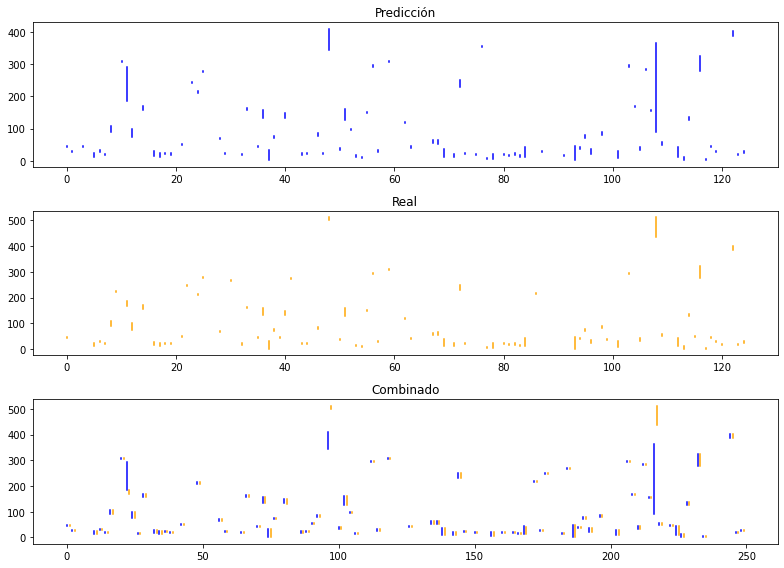

In [ ]:
plot_eval(eval_data)